In [1]:
from schema import WhiteboxSimulation, Schema
from nrel_uitls import CLIMATEZONES, RESTYPES
import json
import numpy as np

schema = Schema()

height = 3
width = 4
facade_2_footprint = 0.303
perim_2_footprint = 0.5

depth = height / facade_2_footprint
area = width * depth
perim_area = perim_2_footprint * area
core_area = (1-perim_2_footprint) * area

with open("./data/city_map.json","r") as f:
    city_map = json.load(f)
storage_vector = schema.generate_empty_storage_vector()
schema.update_storage_vector(storage_vector, parameter="climate_zone", value=CLIMATEZONES["2A"])
schema.update_storage_vector(storage_vector, parameter="vintage", value=1920)
schema.update_storage_vector(storage_vector, parameter="program_type", value=RESTYPES["Multi-Family with 5+ Units"])
schema.update_storage_vector(storage_vector, parameter="base_epw", value=city_map["NY, New York"]["idx"])
schema.update_storage_vector(storage_vector, "height", height)
schema.update_storage_vector(storage_vector, "width", width)
schema.update_storage_vector(storage_vector, "facade_2_footprint", facade_2_footprint)
schema.update_storage_vector(storage_vector, "perim_2_footprint", perim_2_footprint)
schema.update_storage_vector(storage_vector, "roof_2_footprint", 0.0)
schema.update_storage_vector(storage_vector, "footprint_2_ground", 0.0)
schema.update_storage_vector(storage_vector, "wwr", 0.3)
schema.update_storage_vector(storage_vector, "orientation", 0)
schema.update_storage_vector(storage_vector, "HeatingSetpoint", 19)
schema.update_storage_vector(storage_vector, "CoolingSetpoint", 23)
schema.update_storage_vector(storage_vector, "LightingPowerDensity", 4.5)
schema.update_storage_vector(storage_vector, "EquipmentPowerDensity", 1.33)
schema.update_storage_vector(storage_vector, "PeopleDensity", 0.05)
schema.update_storage_vector(storage_vector, "Infiltration", 0.5)
schema.update_storage_vector(storage_vector, "FacadeMass", 32550) 
schema.update_storage_vector(storage_vector, "RoofMass", 37889)
schema.update_storage_vector(storage_vector, "FacadeRValue", 6)
schema.update_storage_vector(storage_vector, "RoofRValue", 6)
schema.update_storage_vector(storage_vector, "SlabRValue", 6)
schema.update_storage_vector(storage_vector, "WindowSettings", np.array([6,0.5,0.7])) 



ERROR:Schema:Failed to import a package! Be wary about continuing...
Traceback (most recent call last):
  File "c:\Users\szvsw\repos\ml-for-building-energy-modeling\ml-for-bem\schema.py", line 25, in <module>
    from pyumi.shoeboxer.shoebox import ShoeBox
ModuleNotFoundError: No module named 'pyumi'


# Run Surrogate

In [2]:
from surrogate import Surrogate
import torch
import matplotlib.pyplot as plt

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
surrogate = Surrogate(schema=schema, checkpoint="batch_permute_lower_lr/batch_permute_lower_lr_202307250612_002_350000.pt")

INFO:Surrogate:Using cuda for surrogate model.
INFO:Surrogate:Loading the full dataset into main RAM...
INFO:Surrogate:Finished loading the full dataset.
INFO:Surrogate:Full Input Batch Size (in storage form, not MLVec Form): 382.750176MB
INFO:Surrogate:Loading climate data...
INFO:Surrogate:Finished loading climate data.
INFO:Surrogate:Permuting dataset...
INFO:Surrogate:Dataset permuted.
INFO:Surrogate:28 building parameters per input vector
INFO:Surrogate:11 timeseries per input vector
INFO:Surrogate:4 timeseries per output vector
INFO:Surrogate:12 timesteps in output.
INFO:Surrogate:Initializing machine learning objects...
INFO:Surrogate:ML objects initialized.


In [11]:
surrogate.full_storage_batch[450000:450000+2].shape

(1, 92)

In [4]:
batch = storage_vector.reshape(1,-1)
batch = np.vstack((batch,batch))
ts = surrogate.get_batch_climate_timeseries(batch)
scheds = surrogate.get_batch_schedules(batch)
ts = np.concatenate((ts,scheds),axis = 1)
bv = surrogate.get_batch_building_vector(batch)
area_norm = (area - surrogate.area_min) / (surrogate.area_max - surrogate.area_min)
perim_area_norm = (perim_area - surrogate.area_perim_min) / (surrogate.area_perim_max - surrogate.area_perim_min)
core_area_norm = (core_area - surrogate.area_core_min) / (surrogate.area_core_max - surrogate.area_core_min)

bv = np.concatenate ([bv, np.array([ [area_norm, perim_area_norm, core_area_norm] ]).repeat(2,axis=0) ], axis=1)
bv = np.repeat(bv.reshape(2,-1,1), surrogate.output_resolution, axis=2)



INFO:Surrogate:Constructing climate timeseries for batch...
INFO:Surrogate:Climate timeseries for batch constructed.
INFO:Surrogate:Constructing schedules for batch...
INFO:Surrogate:Schedules for batch constructed.
INFO:Surrogate:Constructing building vector for batch...
INFO:Surrogate:Building vector for batch constructed.


In [5]:
ts = torch.Tensor(ts).to('cuda')
bv = torch.Tensor(bv).to('cuda')

In [6]:
surrogate.timeseries_net.eval()
surrogate.energy_net.eval()
latent = surrogate.timeseries_net(ts)
x = torch.concatenate((latent,bv), axis=1)
results = surrogate.energy_net(x)

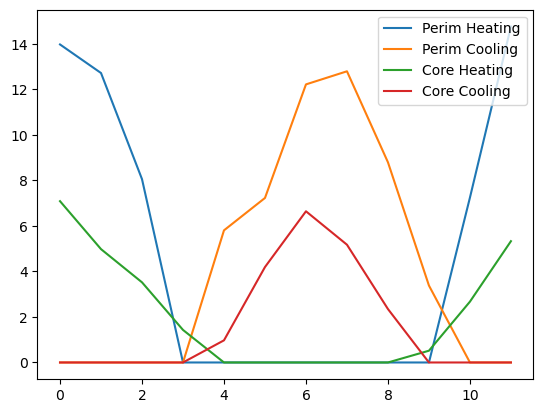

In [12]:
plt.figure()
for i in range(4):
    res = results[0][i].detach().cpu().numpy()
    label = ""
    if i == 0:
        res = res*(surrogate.eui_perim_heating_max - surrogate.eui_perim_heating_min) + surrogate.eui_perim_heating_min
        label = "Perim Heating"
    elif i == 1:
        res = res*(surrogate.eui_perim_cooling_max - surrogate.eui_perim_cooling_min) + surrogate.eui_perim_cooling_min
        label = "Perim Cooling"
    elif i == 2:
        res = res*(surrogate.eui_core_heating_max - surrogate.eui_core_heating_min) + surrogate.eui_core_heating_min
        label = "Core Heating"
    elif i == 3:
        res = res*(surrogate.eui_core_cooling_max - surrogate.eui_core_cooling_min) + surrogate.eui_core_cooling_min
        label = "Core Cooling"
    plt.plot(res, label=label)
plt.legend()

# EPlus Sim

In [2]:
import matplotlib.pyplot as plt

In [3]:
whitebox_sim = WhiteboxSimulation(schema, storage_vector)
whitebox_sim.summarize()
res_h, res_m = whitebox_sim.simulate()



------------------------------
EPW: c:\Users\szvsw\repos\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0001_USA_NY-New York Central Prk Obs Belv.725033_TMY3.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.0
Width 4.0
WWR 0.3
Facade2Foot 0.303
Perim2Foot 0.5
Foot2Gnd [adia %] 0.05
Roof2Gnd [adia %] 0.05
Orientation 0.0
---PERIM/CORE Values---
Heating Setpoint: 19.0 19.0
Cooling Setpoint: 23.0 23.0
Equipment Power Density: 1.33 1.33
Lighting Power Density: 4.5 4.5
People Density: 0.05 0.05
Infiltration: 0.5 0.5
Roof HeatCap: 38392.99128294026 38392.99128294026
Facade HeatCap: 34939.75858762089 34939.75858762089
U Window: 198.82006253010596
VLT 0.7
Roof RSI: 6.0
Facade RSI: 6.0
Slab RSI: 6.0
Partition RSI: 0.6526162790697675
Ground RSI: 6.0
Roof Assembly: [12:Concrete_Dense with thickness of 0.004 m, 19:Plywood_Board with thickness of 0.015 m, 20:Fiberglass_Batts with thickness of 0.248 m, 14:Gypsum_Board with thickness of 0

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-fa34a5bd-2cb8-11ee-a9ba-c4d0e3f88094.idf: 4.00it [00:00, 17.2it/s]
C:\EnergyPlusV9-2-0\energyplus.exe fa34a5bd-2cb8-11ee-a9ba-c4d0e3f88094.idf: 55it [00:01, 34.66it/s]


In [4]:
area = whitebox_sim.shoebox_config.width * whitebox_sim.shoebox_config.height / whitebox_sim.shoebox_config.facade_2_footprint
perim_area = area * perim_2_footprint
core_area = area * (1-perim_2_footprint)
area, perim_area, core_area

(39.603960396039604, 19.801980198019802, 19.801980198019802)

In [5]:
res_m = res_m * 2.777e-7
res_m

IndexGroup                                      System  \
KeyValue   BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name        Zone Ideal Loads Zone Total Heating Energy   
2018-01-01                                  700.562154   
2018-02-01                                  487.020480   
2018-03-01                                  364.691311   
2018-04-01                                  228.584351   
2018-05-01                                  110.934066   
2018-06-01                                   13.674898   
2018-07-01                                    1.718163   
2018-08-01                                   11.859834   
2018-09-01                                   35.702359   
2018-10-01                                  175.140099   
2018-11-01                                  325.068479   
2018-12-01                                  579.573948   

IndexGroup                                             \
KeyValue                                                
Name       Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01                               1.628639e-11   
2018-02-01                               2.773601e+00   
2018-03-01                               1.610829e+01   
2018-04-01                               3.436608e+01   
2018-05-01                               9.003668e+01   
2018-06-01                               1.305248e+02   
2018-07-01                               2.313625e+02   
2018-08-01                               1.839281e+02   
2018-09-01                               1.105483e+02   
2018-10-01                               3.380313e+01   
2018-11-01                               2.339861e+01   
2018-12-01                               9.240938e-01   

IndexGroup                                             \
KeyValue   BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name       Zone Ideal Loads Zone Total Heating Energy   
2018-01-01                                 536.083573   
2018-02-01                                 398.488631   
2018-03-01                                 309.260951   
2018-04-01                                 191.761750   
2018-05-01                                  95.646179   
2018-06-01                                  13.651673   
2018-07-01                                   2.675660   
2018-08-01                                  14.476310   
2018-09-01                                  42.565065   
2018-10-01                                 181.190055   
2018-11-01                                 282.469193   
2018-12-01                                 456.324393   

IndexGroup                                             
KeyValue                                               
Name       Zone Ideal Loads Zone Total Cooling Energy  
2018-01-01                                   0.000009  
2018-02-01                                   0.000106  
2018-03-01                                   0.000173  
2018-04-01                                   1.957090  
2018-05-01                                  15.293134  
2018-06-01                                  16.504090  
2018-07-01                                  53.841283  
2018-08-01                                  25.387001  
2018-09-01                                   1.785300  
2018-10-01                                   0.000055  
2018-11-01                                   0.000048  
2018-12-01                                   0.000011

In [6]:
res_m = res_m.values.T
res_m = res_m / np.array([perim_area, perim_area, core_area, core_area]).reshape(-1,1)


In [22]:
res_m

array([[3.53783888e+01, 2.45945342e+01, 1.84169112e+01, 1.15435097e+01,
        5.60217033e+00, 6.90582366e-01, 8.67672420e-02, 5.98921634e-01,
        1.80296911e+00, 8.84457498e+00, 1.64159582e+01, 2.92684844e+01],
       [8.22462836e-13, 1.40066840e-01, 8.13468679e-01, 1.73548692e+00,
        4.54685226e+00, 6.59150175e+00, 1.16838043e+01, 9.28836931e+00,
        5.58269014e+00, 1.70705816e+00, 1.18162965e+00, 4.66667356e-02],
       [2.70722204e+01, 2.01236759e+01, 1.56176780e+01, 9.68396839e+00,
        4.83013204e+00, 6.89409473e-01, 1.35120824e-01, 7.31053672e-01,
        2.14953579e+00, 9.15009777e+00, 1.42646942e+01, 2.30443818e+01],
       [4.44912262e-07, 5.36361885e-06, 8.72754556e-06, 9.88330624e-02,
        7.72303285e-01, 8.33456547e-01, 2.71898479e+00, 1.28204356e+00,
        9.01576290e-02, 2.78955524e-06, 2.41267909e-06, 5.75733107e-07]])

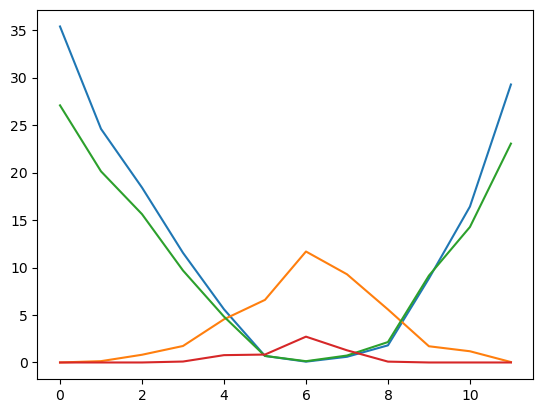

In [8]:
plt.figure()
for i in range(4):
    plt.plot(res_m[i])